# Unsupervised Wildfire Detection Using GOES-16 Imagery  <a class="tocSkip">

This notebook provides a Python pipeline of detecting wildfire from GOES-16 imagery using a robust principal component analysis (RPCA) based algorithm. The detail of this algorithm is described in Xu, Kong and Asgharzadeh (2021, [link](https://stevengxu.github.io/projects/Wildfire_IGARSS.pdf)) which was presented in the 2021 IEEE International Symposium on Geoscience and Remote Sensing (IGARSS).

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Lat/Lon-Projection" data-toc-modified-id="Lat/Lon-Projection-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Lat/Lon Projection</a></span></li></ul></li><li><span><a href="#Kincade-Fire" data-toc-modified-id="Kincade-Fire-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Kincade Fire</a></span><ul class="toc-item"><li><span><a href="#Fire-Perimeter" data-toc-modified-id="Fire-Perimeter-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Fire Perimeter</a></span></li></ul></li><li><span><a href="#Method" data-toc-modified-id="Method-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Method</a></span><ul class="toc-item"><li><span><a href="#Radiance-to-Brightness-Temperature-Conversion" data-toc-modified-id="Radiance-to-Brightness-Temperature-Conversion-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Radiance to Brightness Temperature Conversion</a></span></li><li><span><a href="#Sparse-and-Low-rank-Matrix-Decomposition" data-toc-modified-id="Sparse-and-Low-rank-Matrix-Decomposition-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Sparse and Low-rank Matrix Decomposition</a></span></li><li><span><a href="#Removing-Cloud-Pixels" data-toc-modified-id="Removing-Cloud-Pixels-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Removing Cloud Pixels</a></span></li><li><span><a href="#Removing-Noise-Pixels" data-toc-modified-id="Removing-Noise-Pixels-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Removing Noise Pixels</a></span></li></ul></li><li><span><a href="#Result" data-toc-modified-id="Result-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Result</a></span><ul class="toc-item"><li><span><a href="#Comparison-with-GOES-16-Active-Fire-Product" data-toc-modified-id="Comparison-with-GOES-16-Active-Fire-Product-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Comparison with GOES-16 Active Fire Product</a></span></li></ul></li></ul></div>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

## Introduction

The Geostationary Operational Environmental Satellites (GOES)-16 <a style="text-decoration:none" href="#1">[1]</a>, launched in 2017, is one of the newest weather satellites op-erated by NASA and the National Oceanic and AtmosphericAdministration (NOAA) to provide high frequency Earth imagery and atmospheric measurements.  It scans the continen-tal U.S. (CONUS) every 5 minutes through 16 spectral bands covering visible and infrared wavelengths.  The 2 km spatialresolution and high temporal resolution of GOES-16 imagery makes it suitable for detecting wildfires online.

## Data

Real-time feed and historical archive of GOES-16 Imagery are publicly accessible through <a style="text-decoration:none" href="https://registry.opendata.aws/noaa-goes/">Amazon S3</a>. The `goes2go` package provides function to download and visualize GOES imagery.

In [2]:
from goes2go.data import goes_timerange, goes_latest
import cartopy.crs as ccrs
import xarray as xr
from datetime import datetime

As an example, we can download the latest image and load it into an `xarray`.

In [3]:
dir = 'GOES/'
G_ABI = goes_latest(satellite = 'G16', 
                    domain = 'C', 
                    product = 'ABI',
                    return_as = 'xarray',
                    save_dir = dir)

 _______________________________
 | Satellite: noaa-goes16      |
 |   Product: ABI-L2-MCMIPC    |
 |    Domain: C                |
📦 Finished downloading [1] files to [GOES\noaa-goes16\ABI-L2-MCMIPC].                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [4]:
G_ABI

<xarray.Dataset>
Dimensions:                                 (y: 1500, x: 2500, number_of_time_bounds: 2, number_of_image_bounds: 2, band: 1)
Coordinates: (12/41)
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1282 ... 0.04427
  * x                                       (x) float32 -0.1013 ... 0.03861
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
    dataset_name                            <U74 'OR_ABI-L2-MCMIPC-M6_G16_s20...
    date_created                            <U22 '2021-09-24T00:54:04.8Z'
    time_coverage_start                     <U22 '2021-09-24T00:51:17.2Z'
    time_coverage_end                       <U22 '2021-09-24T00:53:55.1Z'
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds, band
Data variables: (12/125)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
    filename                                <U112 'noaa-goes16/ABI-L2-MCMIPC/...
Attributes: (12/26)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    processing_level:          National Aeronautics and Space Administration ...
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        03a3dd98-f960-4e4a-b9a2-06417153f862
    path:                      ['noaa-goes16/ABI-L2-MCMIPC/2021/267/00/OR_ABI...

In [9]:
scan_start = datetime.strptime(str(G_ABI.time_coverage_start.data), '%Y-%m-%dT%H:%M:%S.%fZ')

The raw data are hyperspectral images across 16 bands. We can project them to a natural color RGB for visualization. We can also overlay the map with various features provided by `cartopy`. Here we specify coastlines and state boundaries.

For a full list of features, see http://www.naturalearthdata.com/downloads/

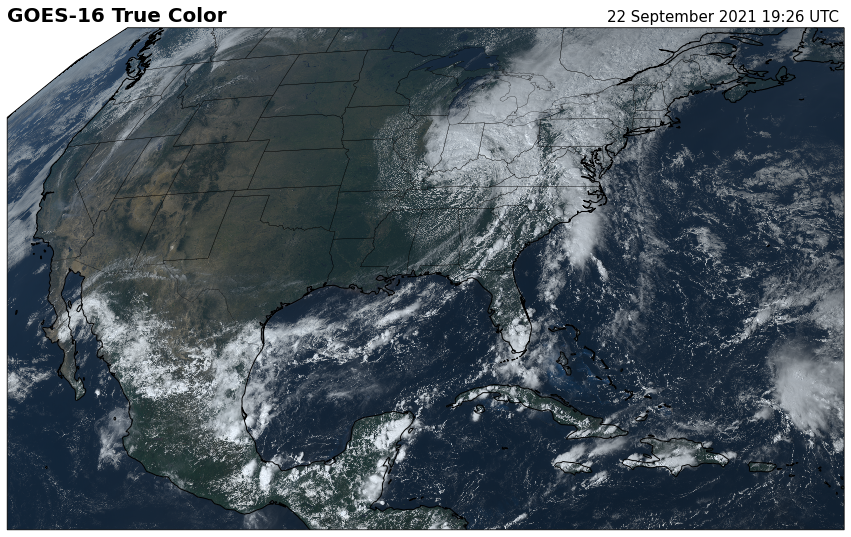

In [10]:
fig = plt.figure(figsize=(15, 12))
ax = plt.subplot(projection=G_ABI.rgb.crs)
ax.imshow(G_ABI.rgb.NaturalColor(), **G_ABI.rgb.imshow_kwargs)
ax.coastlines()
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)
plt.title('GOES-16 True Color', loc='left', fontweight='bold', fontsize=20)
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')), loc='right', fontsize=15)
plt.show()

### Lat/Lon Projection

The coordinates variables of GOES images are x an y which represent horizontal and vertical scan angles in radians.

<figure class="image">
<img src="https://images.squarespace-cdn.com/content/v1/59b037304c0dbfb092fbe894/1543179307299-4CKI9JRKPSMOV98G6O3X/goes_r_radian_projection_angle.png?format=1500w.png" alt="drawing" style="width:600px;"/>
</figure>

<figure class="image">
<img src="https://images.squarespace-cdn.com/content/v1/59b037304c0dbfb092fbe894/1543180940806-VX4ETXWV2R2D6M2M3IY9/goes_r_grid_earth_background.png?format=1500w.png" alt="drawing" style="width:400px;"/>
<figcaption style="text-align:center">Fig. 1: Illustration of GOES-16 coordinate system.</figcaption>
</figure>

Source: [link](https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm)

They can be used to reproject the images to Lat/Lon coordinates using the code below.

In [11]:
#Source: https://github.com/blaylockbk/goes2go/blob/master/latlon_grids/create_standard_GOES_latlon_grids.ipynb

p = G_ABI['goes_imager_projection']

# The projection x and y coordinates equals the scanning angle (in radians)
# multiplied by the satellite height See details here:
# https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = G_ABI['x'][:] * p.perspective_point_height
y = G_ABI['y'][:] * p.perspective_point_height

######################################################################
# The geostationary projection is the easiest way to plot the image on a
# map. Essentially, we are stretching the image across a map with the same
# projection and dimensions as the data.

try:
    print('first try...', end='')
    globe = ccrs.Globe(semimajor_axis=p.semi_major_axis,
                       semiminor_axis=p.semi_minor_axis,
                       inverse_flattening=p.inverse_flattening)
    geos = ccrs.Geostationary(central_longitude=p.longitude_of_projection_origin, 
                              satellite_height=p.perspective_point_height,
                              sweep_axis=p.sweep_angle_axis,
                              globe=globe)

except:
    print('second try')
    globe = ccrs.Globe(semimajor_axis=p.semi_major_axis[0],
                   semiminor_axis=p.semi_minor_axis[0],
                   inverse_flattening=p.inverse_flattening[0])
    geos = ccrs.Geostationary(central_longitude=p.longitude_of_projection_origin[0], 
                              satellite_height=p.perspective_point_height[0],
                              sweep_axis=p.sweep_angle_axis,
                              globe=globe)

first try...

In [12]:
X, Y = np.meshgrid(x,y)
a = ccrs.PlateCarree().transform_points(geos, X, Y)
lons, lats = a[:,:,0], a[:,:,1]
lats[np.isinf(lats)] = np.nan
lons[np.isinf(lons)] = np.nan

Now, Lat/Lon coordinates of (x,y) location can be obtained by
```python
lat,lon = lats[x,y],lons[x,y]
```

We can also store the projected coordinates for future use.
```python
gll = xr.Dataset(dict(latitude=(('y', 'x'), lats), 
                     longitude=(('y', 'x'), lons)))

gll.latitude.attrs = dict(standard_name='latitude', long_name='latitude', units='degrees_north')
gll.longitude.attrs = dict(standard_name='longitude', long_name='longitude', units='degrees_east')

gll.coords['latitude'] = gll.latitude
gll.coords['longitude'] = gll.longitude

gll = gll.where(~np.isinf(gll.latitude))
gll = gll.where(~np.isinf(gll.longitude))

ds.attrs['name'] = f'lat/lon grid for GOES-16 CONUS'

ds = ds.where(~np.isinf(ds.latitude))
ds = ds.where(~np.isinf(ds.longitude))

name = f'./latlon_GOES-16_CONUS.nc'
ds.to_netcdf(name)
ds
```

## Kincade Fire

The Kincade fire was a wildfire that burned in Sonoma County, California in the United States. The fire started northeast of Geyserville in The Geysers on 9:24 p.m. on October 23, 2019 and subsequently burned 77,758 acres until the fire was fully contained on November 6, 2019. (source: [wiki](https://en.wikipedia.org/wiki/Kincade_Fire))

### Fire Perimeter

Fire perimeter are GIS data that map the approximated location of fire. They serve as groundtruth for validating detection results. The <a style="text-decoration:none" href="https://data-nifc.opendata.arcgis.com/datasets/nifc::historic-perimeters-2019/about">National Interagency Fire Center</a> provides fire perimeters for most wildfires that took place in 2019. 

In [13]:
import shapefile as shp

In [14]:
shpFile = r"Historic_GeoMAC_Perimeters_2019\US_HIST_FIRE_PERIM_2019_dd83"
sf = shp.Reader(shpFile)

The variable `sf` is a list of shapeRecords, each shapeRecord stores the points (vertices) that form the fire perimeter. 

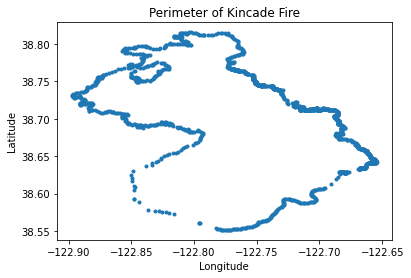

In [15]:
# This index was found manually
kincade_perimeter = sf.shapeRecords()[702].shape.points
lon_list,lat_list = [],[]
for lon,lat in kincade_perimeter:
    lon_list.append(lon)
    lat_list.append(lat)
plt.plot(lon_list,lat_list,'.');
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Perimeter of Kincade Fire")
plt.show()

We can convert the fire perimeter to a Polygon which is a spatial geometry. We can also visualize the Polygon on a map using the `folium` package.

In [16]:
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
import folium
from folium import plugins

# Function to construct polygon and folium map given perimeter
def firePolygon(fire_name,lon_list,lat_list):
    polygon = Polygon(zip(lon_list,lat_list))
    mean_lon, mean_lat = np.mean(lon_list), np.mean(lat_list)
    
    polygon_df = gpd.GeoDataFrame(index=[0],geometry=[polygon]) 
    polygon_df = polygon_df.set_crs(epsg=4326)
    m = folium.Map([mean_lat,mean_lon], zoom_start=10, tiles='Stamen Terrain')
    for _, r in polygon_df.iterrows():
        # Without simplifying the representation of each borough,
        # the map might not be displayed
        sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'stroke':False,'fillColor': 'red'})
        folium.Popup(fire_name).add_to(geo_j)
        geo_j.add_to(m)
    return polygon, polygon_df, m

In [17]:
kincade_polygon, kincade_gdf, kincade_map = firePolygon('Kincade Fire',lon_list,lat_list)

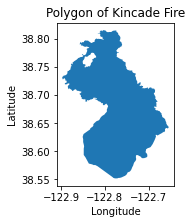

In [18]:
kincade_gdf.plot(figsize=(3,3))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Polygon of Kincade Fire")
plt.show()

We can check if a coordinate, represented by a Point object, falls within the Polygon.

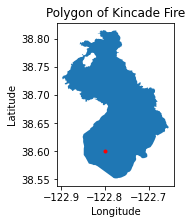

The point with longitude -122.8 and latitude 38.6 is within the Polygon.


In [19]:
kincade_gdf.plot(figsize=(3,3))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Polygon of Kincade Fire")
plt.plot(-122.8, 38.6,'r.')
plt.show()
point = Point(-122.8, 38.6)
if kincade_polygon.contains(point):
    print("The point with longitude %s and latitude %s is within the Polygon."%(point.x,point.y))

In [20]:
kincade_map

## Method

To detect Kincade Fire, we use GOES-16 ABI Radiance images from October 28.

In [21]:
start = '2019-10-28 0:00'
end = '2019-10-28 0:05'

g_rad = goes_timerange(start, end,
                   satellite = 'goes16',
                   product = 'ABI-L1b-Rad',
                   domain = 'C',
                   return_as = 'filelist',
                   save_dir=dir
                  )

 _______________________________
 | Satellite: noaa-goes16      |
 |   Product: ABI-L1b-RadC     |
 |    Domain: C                |
📦 Finished downloading [16] files to [GOES\noaa-goes16\ABI-L1b-RadC].                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [22]:
g_rad

,file,start,end,creation
0,noaa-goes16/ABI-L1b-RadC/2019/301/00/OR_ABI-L1...,2019-10-28 00:01:34.500,2019-10-28 00:04:11.800,2019-10-28 00:04:18.200
1,noaa-goes16/ABI-L1b-RadC/2019/301/00/OR_ABI-L1...,2019-10-28 00:01:34.500,2019-10-28 00:04:11.800,2019-10-28 00:04:16.200
2,noaa-goes16/ABI-L1b-RadC/2019/301/00/OR_ABI-L1...,2019-10-28 00:01:34.500,2019-10-28 00:04:11.800,2019-10-28 00:04:17.500
3,noaa-goes16/ABI-L1b-RadC/2019/301/00/OR_ABI-L1...,2019-10-28 00:01:34.500,2019-10-28 00:04:11.800,2019-10-28 00:04:16.700
4,noaa-goes16/ABI-L1b-RadC/2019/301/00/OR_ABI-L1...,2019-10-28 00:01:34.500,2019-10-28 00:04:11.800,2019-10-28 00:04:22.600
5,noaa-goes16/ABI-L1b-RadC/2019/301/00/OR_ABI-L1...,2019-10-28 00:01:34.500,2019-10-28 00:04:12.400,2019-10-28 00:04:26.100
6,noaa-goes16/ABI-L1b-RadC/2019/301/00/OR_ABI-L1...,2019-10-28 00:01:34.500,2019-10-28 00:04:13.000,2019-10-28 00:04:22.000
7,noaa-goes16/ABI-L1b-RadC/2019/301/00/OR_ABI-L1...,2019-10-28 00:01:34.500,2019-10-28 00:04:11.800,2019-10-28 00:04:20.600
8,noaa-goes16/ABI-L1b-RadC/2019/301/00/OR_ABI-L1...,2019-10-28 00:01:34.500,2019-10-28 00:04:12.400,2019-10-28 00:04:21.300
9,noaa-goes16/ABI-L1b-RadC/2019/301/00/OR_ABI-L1...,2019-10-28 00:01:34.500,2019-10-28 00:04:13.000,2019-10-28 00:04:19.700


Our method only requires 3.9 $\mathrm{\mu m}$ (IR shortwave window) and 12.3 $\mathrm{\mu m}$ ("Dirty" longwave window) band.

In [23]:
g_sw = xr.open_dataset(dir+g_rad['file'][6])
g_lw = xr.open_dataset(dir+g_rad['file'][14])

In [24]:
rad_sw, rad_lw = g_sw['Rad'], g_lw['Rad']

Each pixel in GOES-16 image represents a 2 km $\times$ 2 km region. For our analysis, we crop a 100 km $\times$ 100 km region in Northern California.

In [25]:
xstart, ystart = 450, 100
height, width = 50, 50
xend, yend = xstart+height, ystart+width

In [26]:
rad_sw = rad_sw[xstart:xend,ystart:yend].data
rad_lw = rad_lw[xstart:xend,ystart:yend].data

### Radiance to Brightness Temperature Conversion

We convert radiance data to brightness temperature (BT) data using the function
$$\mbox{BT}=\frac{\mbox{fk}_2}{\mbox{bc}_2\left[\log(\frac{\mbox{fk}_1}{L_{\lambda}}+1)-\mbox{bc}_1\right]}$$
where $L_{\lambda}$ is the radiance value and $\mbox{fk}_1,\mbox{fk}_2,\mbox{bc}_1,\mbox{bc}_2$ are wavelength dependent coefficients. Table of coefficients for different bands can be found in the GOES-R [document](https://www.star.nesdis.noaa.gov/goesr/docs/ATBD/Imagery.pdf).

In [27]:
def r2bt(rad,fk1,fk2,bc1,bc2):
    bt = fk2 / (bc2*(np.log(fk1/rad+1)-bc1))
    return bt

In [28]:
bt_sw = r2bt(rad_sw,2.00774e+05,3.68909e+03,0.50777,0.99929)
bt_lw = r2bt(rad_lw,6.40146e+03,1.16980e+03,0.27049,0.99894)

Our detection statistic is the brightness temperature difference (BTD).

In [29]:
btd = bt_sw - bt_lw

In [30]:
scan_start = datetime.strptime(g_sw.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

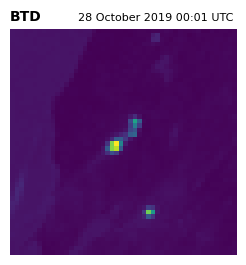

In [31]:
fig,ax = plt.subplots(1,figsize=(3,3),dpi=100)
plt.imshow(btd)
plt.axis("off")
plt.title('BTD', loc='left', fontweight='bold', fontsize=10)
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')), loc='right', fontsize=8)
plt.show()

The BTD image can be seen as superposition of a spatially correlated background matrix and a sparse outlier matrix, where the outliers are potential fire pixels.

### Sparse and Low-rank Matrix Decomposition

Robust Principal Component Analysis (RPCA) <a style="text-decoration:none" href="#2">[2]</a> decomposes an observation matrix into low-rank and sparse components through a two-objective optimization problem,
$$
\min_{\mathbf{L},\mathbf{S}}\ \lVert\mathbf{L}\rVert_*+\lambda\lVert\mathbf{S}\rVert_1\ s.t. \ \mathbf{Y}=\mathbf{L}+\mathbf{S}\label{eq2}
$$
where $\lVert\mathbf{L}\rVert_*$ is the sum of eigenvalues $\sum_i\sigma_i(\mathbf{L})$, and $\lVert\mathbf{S}\rVert_1$ is the $\ell_1$-norm. The penalty coefficient $\lambda$ controls the sparsity of $\mathbf{S}$. It has been proved that under surprisingly broad conditions, the choice of penalty coefficient $\lambda=\frac{1}{\sqrt{\max(m,n)}}$ can exactly recover the low-rank and sparse components <a style="text-decoration:none" href="#2">[2]</a>.

We use a python implementation of RPCA (source: https://github.com/dganguli/robust-pca).

In [32]:
from r_pca import *

In [33]:
rpca = R_pca(btd,lmbda_coef = 1)
L_btd, S_btd = rpca.fit(max_iter=10000, iter_print=10000)

iteration: 1, error: 2.4605280979669835
iteration: 702, error: 3.491573954010701e-05


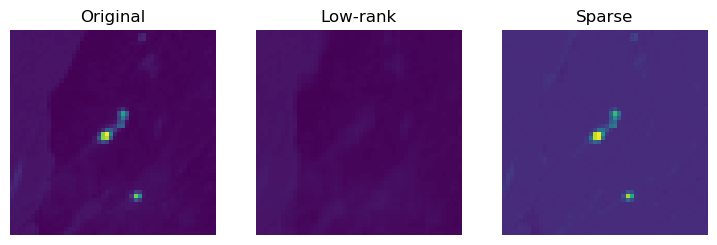

In [34]:
btd_min, btd_max = np.min(btd), np.max(btd)

fig,ax = plt.subplots(1,3,figsize = (9,3), dpi=100)

for i, image in enumerate(zip(['Original','Low-rank','Sparse'],[btd,L_btd,S_btd])):
    name, mat = image
    ax[i].imshow(mat, vmin=btd_min, vmax=btd_max)
    ax[i].title.set_text(name)
    ax[i].axis('off')

plt.show()

### Removing Cloud Pixels

The sparse matrix may contain cloud pixels which are false positives. Water vapor absorbs atmospheric energy at 12.3 $\mu$m, therefore clouds are significantly cooler than the background in the 12.3 $\mu$m band. We propose to identify a pixel in $\mathbf{S}$ as a cloud pixel if its radiance at the 12.3 $\mu$m band, $R_{12.3}$, is significantly low.

The T-point algorithm <a style="text-decoration:none" href="#3">[3]</a> is an automatic image thresholding method based on the pixel density function. It assumes that the pixel density can be approximated by a unimodal histogram with a heavy upper tail. The histogram can be decomposed into three parts: a steep rising slope, a steep descending slope, and a slow descending slope. It then fits a piece-wise linear regression to the steep descending and the low descending slope. The optimal cutoff value is set equivalent to the knot that minimizes the fitting error, such as the $\ell_d$-norm, $d\in\{1,2\}$, of the regression. Let $\mathbf{r}$ denote a vector that stores the sorted negative pixel $R_{12.3}$ of an $m$ by $n$ image in ascending order. If cloud pixels contribute to the lower tail of the $R_{12.3}$ density, then they will contribute to the higher tail of the $-R_{12.3}$ density. Let $\mathbf{r}_{(i)}, \ i\in[1,mn]$ be the $-R_{12.3}$ of the $i$-th entry. If we assume the peak of $-R_{12.3}$ histogram has been identified at index $p$, then the optimal cutoff index $t\in[p+1,mn-1]$ is found by solving the optimization problem
$$
\begin{equation}
t = \text{arg min}\left\{ \sum_{i=p}^{t}\left\lvert \mathbf{r}_{(i)}-\hat{\mathbf{r}}_{(i)}\right\rvert^d+\sum_{i=t}^{mn}\left\lvert \mathbf{r}_{(i)}-\hat{\mathbf{r}}_{(i)}\right\rvert^d\right\} \label{eq3}\tag{1}
\end{equation}
$$
where $\hat{\mathbf{r}}$ are the estimated $-R_{12.3}$ by the fitted regression lines. Following Equation \eqref{eq3}, we will identify a pixel as wildfire only if its $R_{12.3}$ is above $-\mathbf{r}_{(t)}$.

In [35]:
def Tshape_threshold(image_data):
   
    fig,ax = plt.subplots(1,figsize=(4,2),dpi=200)
    #Create pixel histogram
    hist_norm=plt.hist(image_data.ravel(), bins='fd', density=True);
    hist_values=hist_norm[0].tolist()
    hist_axis = hist_norm[1].tolist()
   
    #Get index M corrensponding to peak value vM
    vM=max(hist_values)
    M=hist_values.index(vM)
   
    #Get index L corrensponding to the last non-empty bin
    ne_list = [i for i, v in enumerate(hist_values) if v != 0]
    L=ne_list[-1]
    #print(M,L)
   
    T=M+1
    MSE=999
   
    for k in range(M+1,L-1):
       
        #define the two lines Lsteep and Lslow
        Lsteep_m=(vM-hist_values[k])/(hist_axis[M]-hist_axis[k])
        Lsteep_q=vM - Lsteep_m * hist_axis[M]
        Lslow_m=(hist_values[k] - hist_values[L])/(hist_axis[k]-hist_axis[L])
        Lslow_q=hist_values[k] - Lslow_m * hist_axis[k]
       
       
        #Compute sum of MSE
        MSE_k=0
        for i in range(M,k):
            line = hist_axis[i]*Lsteep_m+Lsteep_q
            MSE_k += (line - hist_values[i])*(line - hist_values[i])
        for i in range(k,L):
            line = hist_axis[i]*Lslow_m+Lslow_q
            MSE_k += (line - hist_values[i])*(line - hist_values[i])
        #print(k, MSE_k, MSE, T)
        MSE_k=MSE_k/(hist_axis[L]-hist_axis[M])
       
        #Update threshold
        if MSE_k < MSE:
            MSE=MSE_k
            T=k
       
   
    #plot
    x1, y1 = [hist_axis[M], hist_axis[T]], [vM, hist_values[T]]
    x2, y2 = [hist_axis[T], hist_axis[L]], [hist_values[T], hist_values[L]]
    plt.plot(x1, y1, x2, y2, marker = 'o')
    plt.vlines(x = x1[1], ymin = 0, ymax = y1[1], linestyles='--', color='k')
    plt.xlabel("$-R_{12.3}$",fontsize=15)
    plt.show()
    #plt.arrow(x1[1], y1[1]/3, 3, 0, head_width = 0.002,head_length = 1.5, color='k', alpha = 0.8)
    return hist_axis[T]

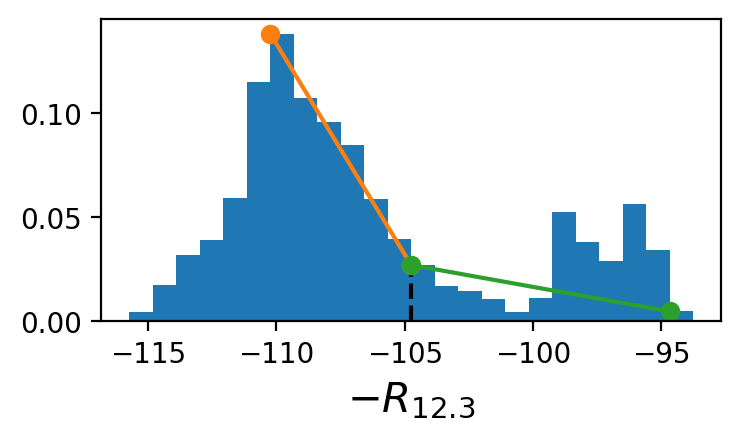

In [36]:
T = -Tshape_threshold(-rad_lw)

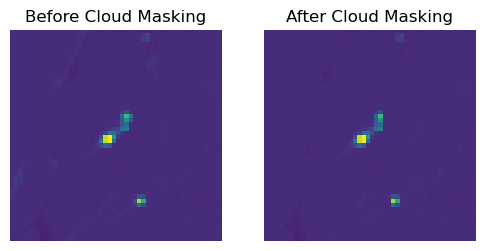

In [37]:
fig,ax = plt.subplots(1,2,figsize = (6,3), dpi=100)

ax[0].imshow(S_btd, vmin=btd_min, vmax=btd_max)
ax[0].title.set_text("Before Cloud Masking")
ax[0].axis('off')

S_btd[rad_lw < T] = 0

ax[1].imshow(S_btd, vmin=btd_min, vmax=btd_max)
ax[1].title.set_text("After Cloud Masking")
ax[1].axis('off')

plt.show()

### Removing Noise Pixels

The sparse matrix can also contain noise due to sun glints and RPCA algorithm itself. We apply a low-pass filter and rule-based threshold to attenuate high-frequency noise.

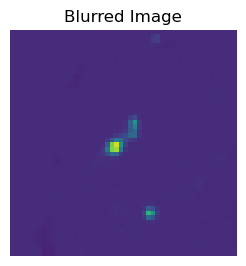

In [38]:
from scipy import ndimage

S_btd_g = ndimage.gaussian_filter(S_btd, sigma=0.5)

fig,ax = plt.subplots(1,figsize = (3,3), dpi=100)

plt.imshow(S_btd_g, vmin=btd_min, vmax=btd_max)
plt.title("Blurred Image")
plt.axis('off')
plt.show()

A threshold value between 5 and 8 generally performs well.

In [39]:
TT = 6

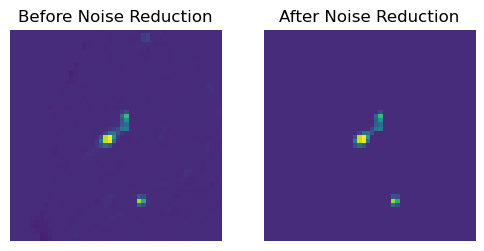

In [40]:
fig,ax = plt.subplots(1,2,figsize = (6,3), dpi=100)

ax[0].imshow(S_btd, vmin=btd_min, vmax=btd_max)
ax[0].title.set_text("Before Noise Reduction")
ax[0].axis('off')

S_btd[S_btd_g < TT] = 0

ax[1].imshow(S_btd, vmin=btd_min, vmax=btd_max)
ax[1].title.set_text("After Noise Reduction")
ax[1].axis('off')

plt.show()

## Result

We can overlay our detection on the map we created before.

In [41]:
fire_points = []
for i in range(height):
    for j in range(width):
        if S_btd[i,j]>0:
            x, y = xstart+i, ystart+j
            lat, lon = lats[x,y], lons[x,y]
            fire_points.append([lat,lon,S_btd[i,j]])

In [42]:
kincade_map.add_child(plugins.HeatMap(fire_points,min_opacity=0.5))
kincade_map.fit_bounds(kincade_map.get_bounds())
kincade_map

<a id='ref'></a>

Our method detected two wildfires, the left one is the Kincade Fire as confirmed by the fire perimeter, the right one is actually the Grizzly Island Fire which started on Oct 28th.

### Comparison with GOES-16 Active Fire Product

GOES-16 has a built-in fire detection algorithm <a style="text-decoration:none" href="#4">[4]</a>. Its results can be extracted similar like other products.

In [43]:
g_fdc = goes_timerange(start, end,
                   satellite = 'goes16',
                   product = 'ABI-L2-FDCC',
                   domain = 'C',
                   return_as = 'xarray',
                   save_dir=dir
                  )

 _______________________________
 | Satellite: noaa-goes16      |
 |   Product: ABI-L2-FDCC      |
 |    Domain: C                |
📦 Finished downloading [1] files to [GOES\noaa-goes16\ABI-L2-FDCC].                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

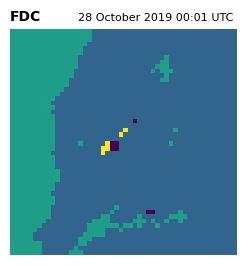

In [44]:
g_fdc_mask = g_fdc['Mask']
g_fdc_mask_ncal = g_fdc_mask[xstart:xend,ystart:yend].data
fig,ax = plt.subplots(1,figsize=(3,3),dpi=100)
plt.imshow(g_fdc_mask_ncal)
plt.title('FDC', loc='left', fontweight='bold', fontsize=10)
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')), loc='right', fontsize=8)
plt.axis("off")
plt.show()

The FDC algorithm assigns each pixel a mask code. Among them, 10-15 and 30-35 correspond to active fire (source: [link](https://www.star.nesdis.noaa.gov/goesr/documents/ATBDs/Baseline/ATBD_GOES-R_FIRE_v2.6_Oct2013.pdf)).

In [45]:
fire_codes = set([i for i in range(10,16)]+[i for i in range(30,36)])

In [46]:
fire_points = []
for i in range(height):
    for j in range(width):
        if g_fdc_mask_ncal[i,j] in fire_codes:
            x, y = xstart+i, ystart+j
            lat, lon = lats[x,y], lons[x,y]
            fire_points.append([lat,lon])

In [47]:
_, _, kincade_map = firePolygon('Kincade Fire',lon_list,lat_list)
kincade_map.add_child(plugins.HeatMap(fire_points,min_opacity=0.5))
kincade_map.fit_bounds(kincade_map.get_bounds())
kincade_map

We see that although FDC successfully identified the two wildfires, it is over-optimistic about the severity of Kincade Fire and yields significantly smaller coverage. In contrast, our method yields a more accurate characterization of the current status of the fire and can help stakeholders better estimate the risk and resources needed to suppress the fire.

## Reference <a class="tocSkip"></a>

<a id="1">[1]</a> 
GOES-R Calibration Working Group and GOES-R Series Program, (2017): NOAA GOES-R Series Advanced Baseline Imager (ABI) Level 1b Radiances. NOAA National Centers for Environmental Information. doi:10.7289/V5BV7DSR. 

<a id="2">[2]</a>
Emmanuel  J  Candès,  Xiaodong  Li,  Yi  Ma,  and  John Wright, "Robust principal component analysis?," *Journal of the ACM (JACM)*, vol. 58, no. 3, pp. 1–37, 2011. 

<a id="3">[3]</a>
Nicolas Coudray, Jean-Luc Buessler, and Jean-Philippe Urban, "Robust threshold estimation for images with uni-modal histograms," *Pattern Recognition Letters*, vol. 31,no. 9, pp. 1010–1019, 2010.

<a id="4">[4]</a>
Christopher C. Schmidt, Jay Hoffman, Elaine Prins, and Scott Lindstrom (2013): GOES-R Advanced Baseline Imager (ABI) Algorithm Theoretical Basis Document For Fire / Hot Spot Characterization. NOAA NESDIS Center for Satellite Applications and
Research.